# Text Preprocessing

In this notebook, we will preprocess our news article summary data to make it ready for fine-tuning in the subsequent notebook. The data will be tokenized using the `google/flan-t5-large` model, and the processed data will be uploaded to our s3 Bucket.

# Import Libraries and Data

In [ ]:
!pip install datasets --quiet
!pip install transformers --quiet

In [28]:
# import libraries
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from datasets import load_dataset

## Load Dataset

We will be using the `xsum` dataset from the Hugging Face Library. It is a dataset that contains news articles and a summary for that news article. You can access it here:

https://huggingface.co/datasets/xsum

In [56]:
# load dataset
data = load_dataset("xsum")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [57]:
data

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [58]:
# obtain a sample of the dataset to reduce number of resources used
sample_data = data.filter(lambda example, index: index % 100 == 0, with_indices = True)
sample_data

Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 2041
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 114
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 114
    })
})

In [59]:
sample_article = sample_data["train"]["document"][0]
sample_summary = sample_data["train"]["summary"][0]

print("ARTICLE:")
print(sample_article)
print()
print("SUMMARY:")
print(sample_summary)

ARTICLE:
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but

In [60]:
train_df = sample_data["train"].to_pandas()

In [61]:
train_df.head()

,document,summary,id
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,35232142
1,South Wales Police are investigating the robbe...,A large amount of cash has been stolen in a da...,32138822
2,"In a Commons debate, the ex-Labour leader said...","Plans for ""English votes for English laws"" are...",33415474
3,All three have joined the Championship side un...,Reading have signed Bournemouth striker Lewis ...,38815218
4,"The 31-year-old Fiji international, who plays ...",Newcastle Falcons have signed Vereniki Goneva ...,35870330


## Visualize the Data

In this step, we'll conduct data visualization to gain insights into our text data. Specifically, we'll create distribution charts to visualize the number of words in each article and summary. These visualizations will be valuable because we'll need to set `input_max_length` and `output_max_length`, which determine the maximum lengths of tokenized inputs and outputs, respectively. Having a clear understanding of the data distribution will help us make informed decisions when specifying these maximum lengths.

In [62]:
# counting the number of words in each article
train_df["document_word_count"] = train_df["document"].str.split().str.len()
document_summary = train_df["document_word_count"].describe(percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])

In [63]:
document_summary

count    2041.000000
mean      380.689858
std       283.885553
min         0.000000
10%       100.000000
20%       159.000000
30%       206.000000
40%       252.000000
50%       304.000000
60%       369.000000
70%       456.000000
80%       583.000000
90%       769.000000
100%     3590.000000
max      3590.000000
Name: document_word_count, dtype: float64

We can see that a a word count of 769 encompasses 90% of the news articles.

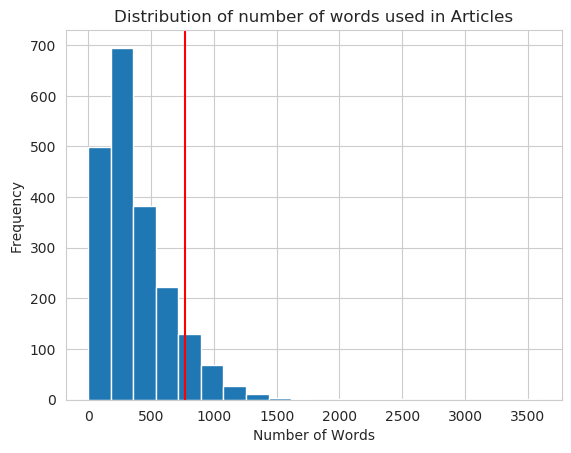

In [64]:
# Plot the distribution of the word numbers per article
train_df["document_word_count"].plot.hist(bins = 20).axvline(x= document_summary['90%'], c = 'red')

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of number of words used in Articles')
plt.show()

In [65]:
train_df["summary_word_count"] = train_df["summary"].str.split().str.len()
summary_summary = train_df["summary_word_count"].describe(percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])

In [66]:
summary_summary

count    2041.000000
mean       21.208721
std         5.130125
min         2.000000
10%        15.000000
20%        17.000000
30%        19.000000
40%        20.000000
50%        21.000000
60%        22.000000
70%        24.000000
80%        25.000000
90%        27.000000
100%       43.000000
max        43.000000
Name: summary_word_count, dtype: float64

We can see that a word count of 43 encompasses 100% of the news articles summaries.

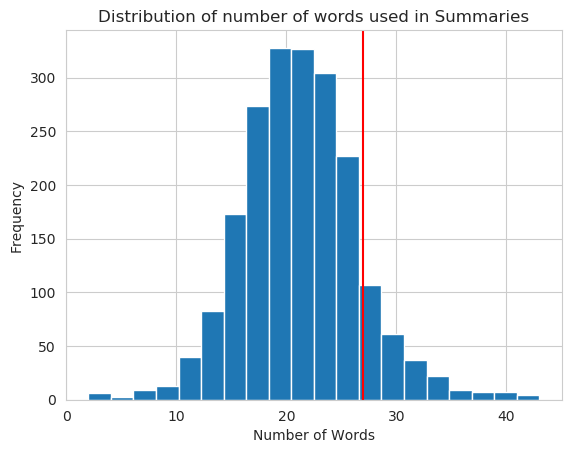

In [67]:
# Plot the distribution of the word numbers per article
train_df["summary_word_count"].plot.hist(bins = 20).axvline(x= summary_summary['90%'], c = 'red')

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of number of words used in Summaries')
plt.show()

# Process Data

In this section we will be using a pretrained tokenizer to tokenize out text data so that the LLM can interpret it.

## Load Tokenizer

The tokenizer we will be using is the `google/flan-t5-large`

In [72]:
# Preprocess data
from transformers import AutoTokenizer

model_checkpoint = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

input_max_length = 1024
output_max_length = 64

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Tokenize Function

The function below is used to build a body of text that contains the instruction, content, and response values from the dataset.

In [78]:
input_max_length = 1024
output_max_length = 64

remove_columns = ["document", "summary", "id"]

def tokenize(examples):
    """
    Tokenize the input news articles and their summaries using tokenizer
    
    Inputs:
        examples (DataFrame): dataframe containing our news articles and summaries
    Outputs:
        model_inputs: dictionary containing the tokenized model inputs and labels for fine-tuning
    """
    
    # prepare inputs for the model by appending "summarize: " to each article
    inputs = ["summarize: " + article for article in examples["document"]]
    
    # Tokenize the input articles using our tokenizer
    model_inputs = tokenizer(inputs, 
                             max_length = input_max_length, 
                             truncation = True)
    
    # Tokenize the summaries using our tokenizer
    labels = tokenizer(text_target = examples["summary"],
                       max_length = output_max_length,
                       truncation = True)
    
    # Store the tokenized summary labels in the model_inputs dictionary
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

`input_max_length` and `output_max_length` are parameters used to control the maximum length of the tokenized inputs and outputs, respectively.

In [79]:
tokenized_data = sample_data.map(tokenize, batched = True, remove_columns = remove_columns)

Map:   0%|          | 0/2041 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

In [80]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 114
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 114
    })
})

## Upload Process Data to S3

In [83]:
# upload dataset to S3

import sagemaker
import boto3

# Initialize sagemaker sessions and get default S3 bucket name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Get IAM role
role = sagemaker.get_execution_role()

# get region name
region = boto3.Session().region_name

In [84]:
# upload processed dataset to S3
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()

s3_prefix = "newsarticle-t5-summary"

dataset_input_path = "s3://{}/{}".format(bucket, s3_prefix)
train_input_path = "{}/train".format(dataset_input_path)
valid_input_path = "{}/validation".format(dataset_input_path)
test_input_path = "{}/test".format(dataset_input_path)

tokenized_data["train"].save_to_disk(train_input_path, fs = s3)
tokenized_data["validation"].save_to_disk(valid_input_path, fs = s3)
tokenized_data["test"].save_to_disk(test_input_path, fs = s3)

/opt/conda/lib/python3.7/site-packages/datasets/arrow_dataset.py:1429: FutureWarning: 'fs' was deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  FutureWarning,


Saving the dataset (0/1 shards):   0%|          | 0/2041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/114 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/114 [00:00<?, ? examples/s]

In [85]:
print(train_input_path)
print(valid_input_path)
print(test_input_path)

s3://sagemaker-us-east-2-003294323742/newsarticle-t5-summary/train
s3://sagemaker-us-east-2-003294323742/newsarticle-t5-summary/validation
s3://sagemaker-us-east-2-003294323742/newsarticle-t5-summary/test
